In [11]:
"""
@author: albertigno

"""

from MyLargeDataset import *
import torch, time, os

import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

True
cuda:0


In [20]:
#os.environ['CUDA_VISIBLE_DEVICES'] = "3"
thresh = 0.3
decay = 0.3
num_classes = 20
batch_size = 256
learning_rate = 1e-4
#learning_rate = 2e-4
time_window = 100
lens= 0.25

# alif - bojian
#lens = 0.5
gamma = 0.5

dataset_path = r'C:\Users\saucedo\Google Drive\Python\SNN Research\datasets'

In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
train_path = dataset_path+'/hd_digits/shd_train.h5'
test_path = dataset_path+'/hd_digits/shd_test.h5'
# load datasets
print("loading test set...")
test_dataset = MyDataset(test_path, 'hd_digits', time_window)
print("loading training set...")
train_dataset = MyDataset(train_path, 'hd_digits', time_window)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

True
cuda:0
loading test set...
ora si merito2
torch.Size([2264, 100, 700])
torch.Size([2264])
num sample: 2264
torch.Size([2264, 100, 700]) torch.Size([2264, 20])
loading training set...
ora si merito2
torch.Size([8156, 100, 700])
torch.Size([8156])
num sample: 8156
torch.Size([8156, 100, 700]) torch.Size([8156, 20])
loading data with pytorch


In [57]:
#multigaussian parameters


class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(thresh).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - thresh) < lens
        return grad_input * temp.float() / (2 * lens)

#    @staticmethod
#    def backward(ctx, grad_output):  # approximate the gradients
#        input, = ctx.saved_tensors
#        grad_input = grad_output.clone()
#        # temp = abs(input) < lens
#        scale = 6.0
#        hight = .15
#        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
#        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
#               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
#               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
#        return grad_input * temp.float() * gamma
    
num_hidden = 256
num_output = 20

best_acc = 0
acc_record = list([])

class SNN_Model(nn.Module):

    def __init__(self, num_classes=20):
        super(SNN_Model, self).__init__()
        
        self.fc_ih = nn.Linear(700, num_hidden, bias= False)
        self.fc_hh = nn.Linear(num_hidden, num_hidden, bias= False)
        self.fc_ho = nn.Linear(num_hidden, num_output, bias= False)
        
        self.tau_m_i = nn.Parameter(torch.Tensor(num_hidden))
        self.tau_m_r = nn.Parameter(torch.Tensor(num_hidden))
        self.tau_m_o = nn.Parameter(torch.Tensor(num_output))
        
        nn.init.normal_(self.tau_m_i,0.8,0.1)
        nn.init.normal_(self.tau_m_r,0.8,0.1)
        nn.init.normal_(self.tau_m_o,3,1)        
        
    def forward(self, input, win):
        
        h0_mem = h0_spike = h0_sumspike = torch.zeros(1, batch_size, num_hidden, device=device)
        h1_mem = h1_spike = h1_sumspike = torch.zeros(1, batch_size, num_hidden, device=device)
        h2_mem = h2_spike = h2_sumspike = torch.zeros(1, batch_size, num_output, device=device)
        
        dense_input = input.to_dense()
        dense_input = 1*(dense_input > 0).float()
        
        for step in range(win):
            
            x = dense_input[:, step, :]
            x = x.view(1, batch_size, -1)

            h0_mem, h0_spike = mem_update_rnn(self.fc_ih, self.fc_hh, x, h0_spike, h0_mem, h0_spike, self.tau_m_i)
            
            h1_mem, h1_spike = mem_update_rnn(self.fc_hh, self.fc_hh, h0_spike, h1_spike, h1_mem, h1_spike, self.tau_m_r)
                        
            h2_mem, h2_spike = mem_update(self.fc_ho, h1_spike, h2_mem, h2_spike, self.tau_m_o)

            h2_sumspike += h2_spike
        
        outputs = h2_sumspike / (win)
        
        return outputs[0]    
    
    
def mem_update(operation, x, mem, spike, tau_m):
    
    #decay = torch.exp(-1. / tau_m).cuda()
    decay = 0.3 
    mem = mem * decay * (1 - spike) + operation(x)
    spike = act_fun(mem)
    mem = mem*(mem<thresh)
    return mem, spike

def mem_update_rnn(operation1, operation2, x, h, mem, spike, tau_m):
    a = operation1(x)
    b = operation2(h)
    decay = torch.exp(-1. / tau_m).cuda()
    
    #print(decay)
    c = mem * decay * (1 - spike) 
    mem = a + b + c
    spike = act_fun(mem)
    mem = mem*(mem<thresh)
    return mem, spike

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma

In [58]:
snn = SNN_Model()

num_epochs = 100
    
snn.to(device)

criterion = nn.MSELoss()

modelname = 'heidelberg_rnn_{}+{}_alif.t7'.format(num_hidden, num_hidden)

def lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=100):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""

    if epoch % lr_decay_epoch == 0 and epoch > 1:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.98

    return optimizer

optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

act_fun = ActFun.apply
print(modelname)
torch.autograd.set_detect_anomaly(True)

heidelberg_rnn_256+256_alif.t7


In [59]:
win = 50
best_acc = 0
train_loss = []
test_loss = []

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')

for epoch in range(num_epochs):
    running_loss = 0
    total_loss_train = 0
    start_time = time.time()
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        
        snn.zero_grad()
        optimizer.zero_grad()

        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = snn(images, win)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        total_loss_train += loss.item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
        if (i + 1) % 50 == 0:
            # print( outputs.sum(dim=0) )
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.5f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, running_loss))
            running_loss = 0
            print('Time elasped:', time.time() - start_time)
    train_loss.append(total_loss_train / total)
    
    optimizer = lr_scheduler(optimizer, epoch, learning_rate, 1)
    
    correct = 0
    total = 0
    total_loss_test = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.float().to(device)
        outputs = snn(images, win)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        _, reference = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == reference).sum()
        total_loss_test += loss.item() 

    print('Iters:', epoch, '\n\n\n')
    print('Test Accuracy of the model on the test samples: %.3f' % (100 * correct.float() / total))
    
    print('Train loss: {}, Test loss: {}'.format(total_loss_train, total_loss_test))
    
    acc = 100. * float(correct) / float(total)
    acc_record.append(acc)
    
    test_loss.append(total_loss_test / total)
    state = {
    'net': snn.state_dict(),
    'acc': acc,
    'epoch': epoch,
    'acc_record': acc_record,
    'train_loss': train_loss,
    'test_loss': test_loss
    }    
    
    if acc>best_acc:
        print('Saving best accuracy so far..')
        print(acc)
        torch.save(state, './checkpoint/' + modelname,  _use_new_zipfile_serialization=False)
        best_acc = acc

Iters: 0 



Test Accuracy of the model on the test samples: 11.768
Train loss: 1.5370092429220676, Test loss: 0.3837190680205822
Saving best accuracy so far..
11.767578125
Iters: 1 



Test Accuracy of the model on the test samples: 20.410
Train loss: 1.4639973975718021, Test loss: 0.36944953352212906
Saving best accuracy so far..
20.41015625
Iters: 2 



Test Accuracy of the model on the test samples: 28.271
Train loss: 1.4103828705847263, Test loss: 0.35408157482743263
Saving best accuracy so far..
28.271484375
Iters: 3 



Test Accuracy of the model on the test samples: 29.248
Train loss: 1.3504315167665482, Test loss: 0.34276899695396423
Saving best accuracy so far..
29.248046875
Iters: 4 



Test Accuracy of the model on the test samples: 35.742
Train loss: 1.2975425384938717, Test loss: 0.32979562878608704
Saving best accuracy so far..
35.7421875
Iters: 5 



Test Accuracy of the model on the test samples: 43.115
Train loss: 1.244735423475504, Test loss: 0.317502036690712
Saving

Iters: 55 



Test Accuracy of the model on the test samples: 64.209
Train loss: 0.5827559679746628, Test loss: 0.20738953538239002
Iters: 56 



Test Accuracy of the model on the test samples: 65.674
Train loss: 0.5801513474434614, Test loss: 0.2046930529177189
Iters: 57 



Test Accuracy of the model on the test samples: 63.574
Train loss: 0.5675690975040197, Test loss: 0.20939406007528305
Iters: 58 



Test Accuracy of the model on the test samples: 64.355
Train loss: 0.5646987659856677, Test loss: 0.20763985253870487
Iters: 59 



Test Accuracy of the model on the test samples: 65.918
Train loss: 0.5674950201064348, Test loss: 0.20480117201805115
Iters: 60 



Test Accuracy of the model on the test samples: 62.451
Train loss: 0.565495952963829, Test loss: 0.21435930021107197
Iters: 61 



Test Accuracy of the model on the test samples: 66.113
Train loss: 0.5634630620479584, Test loss: 0.2023958619683981
Saving best accuracy so far..
66.11328125
Iters: 62 



Test Accuracy of the mo

In [ ]:
state = {
'net': snn.state_dict(),
'acc': acc,
    
    
    
'epoch': epoch,
'acc_record': acc_record,
'train_loss': train_loss,
'test_loss': test_loss
}    

mf = modelname.split('.')[0] + '_final.t7'
torch.save(state, './checkpoint/' + mf ,  _use_new_zipfile_serialization=False)

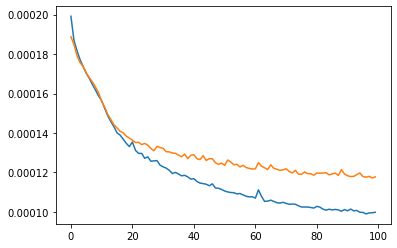

In [96]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_loss)

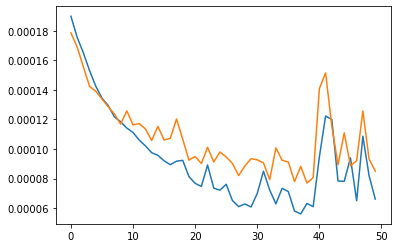

In [37]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_loss)

In [19]:
def get_accuracy(model):
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        outputs = model(images, win)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    
    acc = 100 * correct.float() / total
    return acc

acc = get_accuracy(model)

print('Test Accuracy of the model on the 10000 test images: %.3f' % (acc))

Test Accuracy of the model on the 10000 test images: 70.264


In [97]:
import torch
import numpy as np
import os

print("loading trained model")
model_to_load = modelname

#snn_state_dict = torch.load('./checkpoint/'+modelname, map_location=torch.device('cpu'))['net']
snn_state_dict = torch.load('./checkpoint/'+model_to_load, map_location=torch.device('cpu'))['net']
print(snn_state_dict.keys())

layers_location = 'checkpoint/'+model_to_load.split('.')[0]

if not os.path.isdir(layers_location):
    os.mkdir(layers_location)

weights_biases = []
for k in snn_state_dict:
    np.savez(layers_location+'/'+k,snn_state_dict[k].data.cpu().numpy())
    weights_biases.append(snn_state_dict[k].data.cpu().numpy())

loading trained model
odict_keys(['fc_ih.weight', 'fc_hh.weight', 'fc_ho.weight'])


In [17]:
model_to_load = modelname
#model_to_load = 'heidelberg_rnn_400_mem1.t7'
snn_state_dict = torch.load('./checkpoint/'+model_to_load, map_location=torch.device('cpu'))['net']

model = SNN_Model()
model.load_state_dict(snn_state_dict)
model.to(device)
model.eval()

num_to_test = 50
for images, labels in test_loader:
    images = images.float().to(device)
    labels = labels.float().to(device)
    outputs = model(images, win)
    _, predicted = torch.max(outputs[:num_to_test,:].data, 1)
    _, reference = torch.max(labels[:num_to_test,:].data, 1)
    correct = (predicted == reference).sum()
    break

print('Test Accuracy of the model on the 10000 test images: %.3f' % (100 * correct.float() / num_to_test))

Test Accuracy of the model on the 10000 test images: 66.000


#### SpiNNaker: 50 muestras, 58%